In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

### Boston Public Library and Boston City Hall Electricity Consumption

We will analyze the electrical consuption data from Boston Public Library sampled every 5 min and Boston City Hall sampled every 15 min over a two year period from 2016 to 2017.

The data is again separated by date stamp, but we will focus on analyzing BPL for simplicity.



#### Loading the data and setting the DateTimeIndex

In [2]:
dataBPL = pd.read_csv('https://data.boston.gov/dataset/652762e9-2556-47cd-8e80-798546992a57/resource/87c759ee-63b9-4aec-a00b-bba1672a20ef/download/copleylibraryelectricuse.csv', skipinitialspace=True,
                   low_memory=False)
dataCH = pd.read_csv('https://data.boston.gov/dataset/1b894599-21ff-478f-937d-653954977951/resource/f123e65d-dc0e-4c83-9348-ed46fec498c0/download/cityhallelectricuse.csv', skipinitialspace=True,
                   low_memory=False)

In [3]:
dataBPL['Date'] = pd.to_datetime(dataBPL['DateTime_Measured'])
dataBPL.set_index('Date', inplace=True)

dataBPL['Year'] = dataBPL.index.year
dataBPL['Month'] = dataBPL.index.month
dataBPL['Day']= dataBPL.index.day
dataBPL['Weekday']= dataBPL.index.weekday
dataBPL['Hour']= dataBPL.index.hour
dataBPL['Time'] = dataBPL.index.time

In [4]:
dataCH['Date'] = pd.to_datetime(dataCH['DateTime_Measured'])
dataCH.set_index('Date', inplace=True)

dataCH['Year'] = dataCH.index.year
dataCH['Month'] = dataCH.index.month
dataCH['Day']= dataCH.index.day
dataCH['Weekday']= dataCH.index.weekday
dataCH['Hour']= dataCH.index.hour
dataCH['Time'] = dataCH.index.time

#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [5]:
# Filter to store 1 sales and average over weeks
#store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
#store1_sales.head()

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/Users/ebola/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=6,center=False).mean()
  


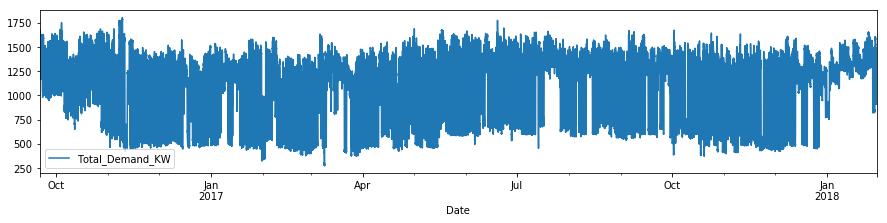

In [12]:
#BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 3).resample('12H').mean()
BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 6).resample('10min').mean()
#CH_electric = pd.rolling_mean(dataCH[['Total_Demand_KW']], 3).resample('D').mean()
BPL_electric.plot(figsize=(15,3))
#CH_electric.plot(figsize=(15,3),color='g')
#dataBPL[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()
#dataCH[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()

#### Compute the 1, 24, 168 autocorrelations for Boston Public Library Hourly_KW and autocorrelation plot.

In [50]:
print('Autocorrelation 1: ', BPL_electric['Total_Demand_KW'].autocorr(1))
print('Autocorrelation 7: ', BPL_electric['Total_Demand_KW'].autocorr(2))
print('Autocorrelation 168: ', BPL_electric['Total_Demand_KW'].autocorr(14))

('Autocorrelation 1: ', 0.3001177700824097)
('Autocorrelation 7: ', 0.69575397857224563)
('Autocorrelation 168: ', 0.66163151568282685)


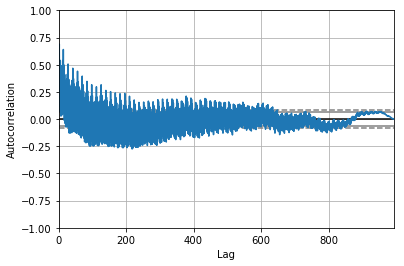

In [51]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(BPL_electric['Total_Demand_KW'])
#autocorrelation_plot(CH_electric['Total_Demand_KW'])

In [52]:
BPL_electric.tail(5)

,Total_Demand_KW
Date,
2018-01-28 00:00:00,988.770833
2018-01-28 12:00:00,1190.613426
2018-01-29 00:00:00,1164.872685
2018-01-29 12:00:00,1424.405093
2018-01-30 00:00:00,1054.706271


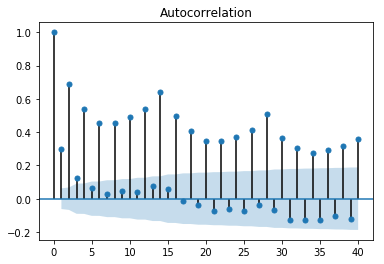

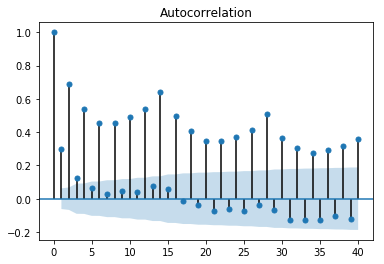

In [53]:
from statsmodels.graphics.tsaplots import plot_acf

#plot_acf(dataBPL['Total_Demand_KW'], lags=10000)
plot_acf(BPL_electric['Total_Demand_KW'], lags=40)

# The dataBPL dataset is sampled every 5 minutes and show correlation peaks every 
# 7 day (2016 data points) cycles and subpeaks every 24 hours. The correlation 
# factor is 0.8 at 168 hours (weekly) 

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

In [54]:
BPL_electric.tail()

,Total_Demand_KW
Date,
2018-01-28 00:00:00,988.770833
2018-01-28 12:00:00,1190.613426
2018-01-29 00:00:00,1164.872685
2018-01-29 12:00:00,1424.405093
2018-01-30 00:00:00,1054.706271


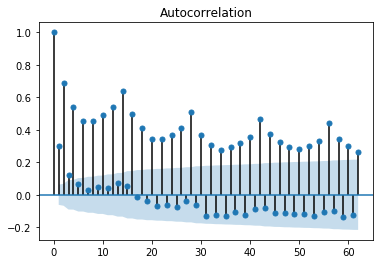

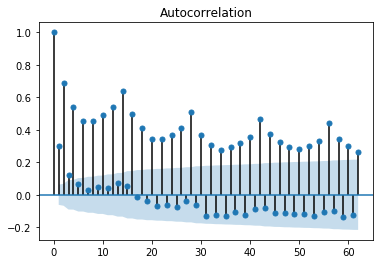

In [55]:

plot_acf(BPL_electric['Total_Demand_KW'], lags=62)

##### Split the energy consumption (5 min) data in a training and test set - using 75% of the data for training

In [56]:
#n = len(dataBPL.Total_Demand_KW)
n = len(BPL_electric.Total_Demand_KW)
#train = dataBPL.Total_Demand_KW[:int(.75*n)]
#test = dataBPL.Total_Demand_KW[int(.75*n):]
train = BPL_electric.Total_Demand_KW[:int(.95*n)]
test = BPL_electric.Total_Demand_KW[int(.95*n):]

In [57]:
test.head(5)

Date
2018-01-05 12:00:00    1244.222222
2018-01-06 00:00:00    1197.351852
2018-01-06 12:00:00    1263.148148
2018-01-07 00:00:00    1177.453704
2018-01-07 12:00:00    1225.393519
Freq: 12H, Name: Total_Demand_KW, dtype: float64

In [58]:
test.tail(5)

Date
2018-01-28 00:00:00     988.770833
2018-01-28 12:00:00    1190.613426
2018-01-29 00:00:00    1164.872685
2018-01-29 12:00:00    1424.405093
2018-01-30 00:00:00    1054.706271
Freq: 12H, Name: Total_Demand_KW, dtype: float64

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [59]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [63]:
#model = sm.tsa.ARIMA(train, (2, 1, 0)).fit()
#print(model.params)

In [64]:
model = sm.tsa.ARIMA(train, (14, 1, 0)).fit()
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.
predictions = model.predict(
    '2018-01-05 12:00:00',
    '2018-01-30 10:00:00',
    dynamic=True
)
#predictions = model.predict(
#    '2016-12-31 17:10:00',
#    '2017-10-31 08:10:00',
#    dynamic=True, 
#)
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 1342.3375066170058)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                  942
Model:                ARIMA(14, 1, 0)   Log Likelihood               -5708.395
Method:                       css-mle   S.D. of innovations            103.272
Date:                Tue, 30 Jan 2018   AIC                          11448.790
Time:                        10:49:56   BIC                          11526.358
Sample:                    09-21-2016   HQIC                         11478.356
                         - 01-05-2018                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2715      0.848     -0.320      0.749      -1.933       1.390
ar.L1.D.Total_Demand_KW     -0.4238      0.031    -13.597      0.000      -0.485      -0.363
ar.L2.D.Total_Demand_KW     -0.2347      0.033     -7.047      0.000      -0.300      -0.169
ar.L3.D.Total_Demand_KW     -0.3587      0.034    -10.546      0.000      -0.425      -0.292
ar.L4.D.Total_Demand_KW     -0.2686      0.035     -7.588      0.000      -0.338      -0.199
ar.L5.D.Total_Demand_KW     -0.2707      0.036     -7.490      0.000      -0.342      -0.200
ar.L6.D.Total_Demand_KW     -0.2997      0.037     -8.162      0.000      -0.372      -0.228
ar.L7.D.Total_Demand_KW     -0.2878      0.037     -7.715      0.000      -0.361      -0.215
ar.L8.D.Total_Demand_KW     -0.2299      0.037     -6.155      0.000      -0.303      -0.157
ar.L9.D.Total_Demand_KW     -0.1998      0.037     -5.437      0.000      -0.272      -0.128
ar.L10.D.Total_Demand_KW    -0.1710      0.036     -4.714      0.000      -0.242      -0.100
ar.L11.D.Total_Demand_KW    -0.2150      0.036     -6.043      0.000      -0.285      -0.145
ar.L12.D.Total_Demand_KW    -0.1094      0.034     -3.198      0.001      -0.176      -0.042
ar.L13.D.Total_Demand_KW    -0.2264      0.033     -6.768      0.000      -0.292      -0.161
ar.L14.D.Total_Demand_KW     0.3084      0.031      9.883      0.000       0.247       0.370
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0027           -0.0000j            1.0027           -0.5000
AR.2            -0.9243           -0.4432j            1.0251           -0.4288
AR.3            -0.9243           +0.4432j            1.0251            0.4288
AR.4            -0.6590           -0.8297j            1.0596           -0.3568
AR.5            -0.6590           +0.8297j            1.0596            0.3568
AR.6            -0.2274           -1.0514j            1.0757           -0.2839
AR.7            -0.2274           +1.0514j            1.0757            0.2839
AR.8             0.2339           -1.0323j            1.0585           -0.2145
AR.9             0.2339           +1.0323j            1.0585            0.2145
AR.10            0.6792           -0.8320j            1.0740           -0.1410
AR.11            0.6792           +0.8320j            1.0740            0.1410
AR.12            0.9510           -0.4691j            1.0604           -0.0729
AR.13            0.9510           +0.4691j            1.0604            0.0729
AR.14            1.6302           -0.0000j            1.6302           -0.0000
------------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

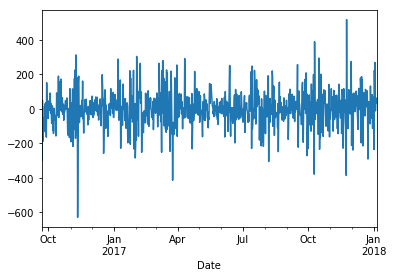

In [65]:
model.resid.plot()

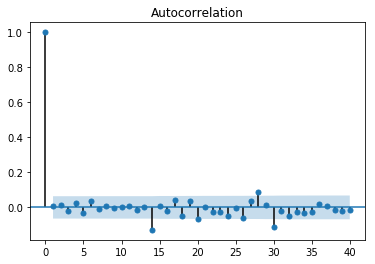

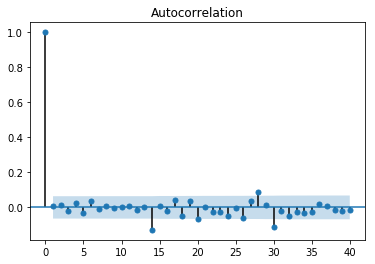

In [66]:
plot_acf(model.resid, lags=40)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [40]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2018-01-05 14:00:00',
    '2018-01-30 08:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 285.67841071818867)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1885
Model:                     ARMA(2, 0)   Log Likelihood              -13292.720
Method:                       css-mle   S.D. of innovations            279.413
Date:                Tue, 30 Jan 2018   AIC                          26593.440
Time:                        10:23:23   BIC                          26615.607
Sample:                    09-21-2016   HQIC                         26601.604
                         - 01-05-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1073.0695      4.768    225.072      0.000    1063.725    1082.414
ar.L1.Total_Demand_KW     0.2165      0.019     11.403      0.000       0.179       0.254
ar.L2.Total_Demand_KW    -0.5669      0.019    -29.859      0.000      -0.604      -0.530
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1910           -1.3144j            1.3282           -0.2270
AR.2            0.1910           +1.3144j            1.3282            0.2270
-----------------------------------------------------------------------------
"""

In [41]:
model = sm.tsa.ARIMA(train, (2, 0, 1)).fit()

predictions = model.predict(
    '2018-01-05 14:00:00',
    '2018-01-30 08:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 285.37761056804015)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1885
Model:                     ARMA(2, 1)   Log Likelihood              -13242.124
Method:                       css-mle   S.D. of innovations            272.004
Date:                Tue, 30 Jan 2018   AIC                          26494.249
Time:                        10:23:58   BIC                          26521.957
Sample:                    09-21-2016   HQIC                         26504.453
                         - 01-05-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1073.1205      5.099    210.462      0.000    1063.127    1083.114
ar.L1.Total_Demand_KW     0.0862      0.023      3.774      0.000       0.041       0.131
ar.L2.Total_Demand_KW    -0.5704      0.019    -29.688      0.000      -0.608      -0.533
ma.L1.Total_Demand_KW     0.2076      0.020     10.636      0.000       0.169       0.246
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0755           -1.3219j            1.3241           -0.2409
AR.2            0.0755           +1.3219j            1.3241            0.2409
MA.1           -4.8162           +0.0000j            4.8162            0.5000
-----------------------------------------------------------------------------
"""

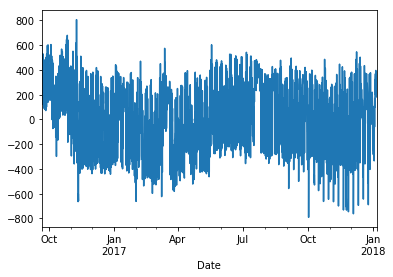

In [42]:
model.resid.plot()

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [43]:
model = sm.tsa.ARIMA(train, (2, 1, 2)).fit()

predictions = model.predict(
    '2018-01-05 14:00:00',
    '2018-01-30 08:00:00',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 136.77186656303618)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                 1884
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12677.397
Method:                       css-mle   S.D. of innovations            202.153
Date:                Tue, 30 Jan 2018   AIC                          25366.793
Time:                        10:24:22   BIC                          25400.040
Sample:                    09-21-2016   HQIC                         25379.038
                         - 01-05-2018                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1490      2.450     -0.061      0.952      -4.952       4.653
ar.L1.D.Total_Demand_KW     0.0131      0.008      1.602      0.109      -0.003       0.029
ar.L2.D.Total_Demand_KW    -0.9432      0.009   -107.107      0.000      -0.960      -0.926
ma.L1.D.Total_Demand_KW    -0.5325      0.028    -19.111      0.000      -0.587      -0.478
ma.L2.D.Total_Demand_KW     0.5478      0.020     27.072      0.000       0.508       0.587
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0069           -1.0297j            1.0297           -0.2489
AR.2            0.0069           +1.0297j            1.0297            0.2489
MA.1            0.4861           -1.2607j            1.3512           -0.1914
MA.2            0.4861           +1.2607j            1.3512            0.1914
-----------------------------------------------------------------------------
"""

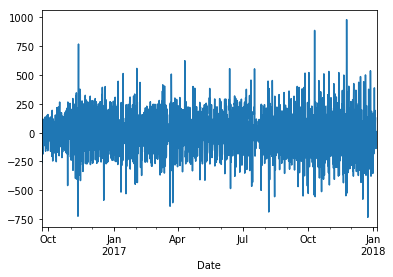

In [44]:
model.resid.plot()

ValueError: Start must be <= len(endog)

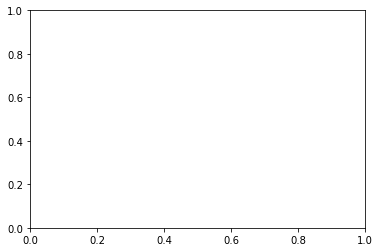

In [67]:
model.plot_predict(1400, 1500)

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

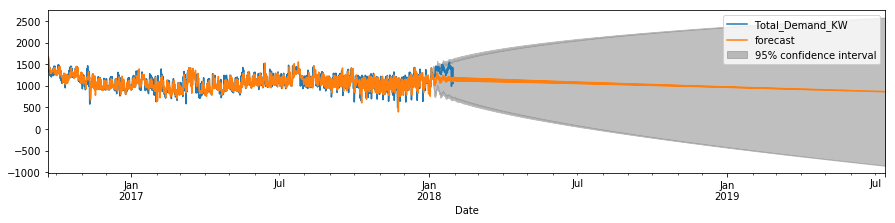

In [69]:
fig, ax = plt.subplots()
ax = BPL_electric.plot(ax=ax,figsize=(15,3))

fig = model.plot_predict(1, 2050, ax=ax, plot_insample=False)